In [1]:
from rtgemlib import RTGEM
from rtgemlib import sample_from_tgem, LogLikelihood, scoreBic, mle_lambdas, LocaleLogLikelihood, get_count_duration_df, get_node_LogLikelihood, set_pcv_lambda_t, backward_neighbors_gen,\
compute_logLikelihood, set_nodes_timeseries, set_nodes_parents_counts, duration, get_parents_count_vector, forward_neighbors_gen

from tqdm.autonotebook import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

C:\Users\Mathilde\Anaconda35\lib\site-packages\tqdm\autonotebook\__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [2]:
def empty_nodes(nodes):
    return dict(zip(nodes, [{'timescales': {}, 'lambdas': {(): 1}}] * len(nodes)))

In [3]:
model = {'B': 
            {
            'timescales': {'A' : [[1,2], [5, 6]]},\
            'lambdas': {
                       (0,0): 10, \
                       (0,1): 1.6, \
                       (1,0): 3, \
                       (1,1) : 1
                      }
            },
            'A': {
                'timescales': {'B': [[0,1], [10,15]]},\
                'lambdas': {
                       (0,0): 1, \
                       (0,1): 4, \
                       (1,0): 5, \
                       (1,1) : 9
                      }
            }
        }



In [4]:
rtgem_model = RTGEM(model)

In [5]:
t_max = 10000

## Sampling

In [6]:
sampled_data = sample_from_tgem(rtgem_model, t_min=0, t_max=t_max)

HBox(children=(IntProgress(value=0, description='Sampled Nodes: ', max=1, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Sampling A, B:', style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='exporting data to DF', max=2, style=ProgressStyle(description_width='initial')), HTML(value='')))

In [7]:
set_pcv_lambda_t(model=rtgem_model, data=sampled_data, t_max=t_max)

In [8]:
count_duration_df = get_count_duration_df(model=rtgem_model, data=sampled_data, t_max=t_max)

In [9]:
count_duration_df

,event,pcv,lambda_t,duration,count
0,B,"(0, 0)",10.0,1.376972,10
1,B,"(0, 1)",1.6,33.621552,45
2,B,"(1, 0)",3.0,37.621552,77
3,B,"(1, 1)",1.0,9927.379924,10341
4,A,"(0, 0)",1.0,17.509759,13
5,A,"(0, 1)",4.0,3367.119940,13236
6,A,"(1, 0)",5.0,53.895655,283
7,A,"(1, 1)",9.0,6561.474646,58987


## Likelihood

In [10]:
compute_logLikelihood(count_duration_df)

65624.37000540116

In [11]:
LogLikelihood(model=rtgem_model, observed_data=sampled_data, t_max=t_max)

65624.37000540116

## Parameters learning (lambdas)

In [12]:
mle_lambdas(data=sampled_data, model=rtgem_model, t_max=t_max)

,event,pcv,lambda_t,duration,count
0,B,"(0, 0)",7.262311,1.376972,10
1,B,"(0, 1)",1.338427,33.621552,45
2,B,"(1, 0)",2.046699,37.621552,77
3,B,"(1, 1)",1.041665,9927.379924,10341
4,A,"(0, 0)",0.742443,17.509759,13
5,A,"(0, 1)",3.930956,3367.119940,13236
6,A,"(1, 0)",5.250887,53.895655,283
7,A,"(1, 1)",8.989900,6561.474646,58987


## Structure learning

### Modèle de référence

In [13]:
rtgem_model = RTGEM(empty_nodes(['A', 'B']), default_end_timescale=1)

In [14]:
rtgem_model.add_edge_operator(('A', 'A'))
rtgem_model.add_edge_operator(('A', 'B'))
rtgem_model.add_edge_operator(('B', 'A'))

In [15]:
rtgem_model.split_operator(edge=('A', 'A'), timescale=[0,1])

In [16]:
rtgem_model.extend_operator(edge=('A', 'B'))

In [17]:
sampled_data = sample_from_tgem(rtgem_model, t_min=0, t_max=10000)

HBox(children=(IntProgress(value=0, description='Sampled Nodes: ', max=1, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Sampling A, B:', style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='exporting data to DF', max=2, style=ProgressStyle(description_width='initial')), HTML(value='')))

In [18]:
t_max = 1000
data = sampled_data[sampled_data['time'] < t_max]

In [19]:
score_bic_reference = scoreBic(model=rtgem_model, observed_data=data, t_max=t_max)

In [20]:
score_bic_reference

2101.930790728022

### Forward Search

In [21]:
import itertools
import random
import copy

In [22]:
def empty_nodes(nodes):
    return dict(zip(nodes, [{'timescales': {}, 'lambdas': {(): 1}}] * len(nodes)))

In [23]:
model = RTGEM(empty_nodes(['A', 'B']),  default_end_timescale=1)

#### Initialisation 

In [24]:
model = set_nodes_timeseries(model, data)
model = set_nodes_parents_counts(model, model.dpd_graph.nodes, t_max)
set_pcv_lambda_t(model, data, t_max)

lambdas_count_duration_df = get_count_duration_df(data, model, t_max)

LogL = compute_logLikelihood(lambdas_count_duration_df)
log_td = np.log(t_max)

size_log_td = model.size() * log_td

score = LogL - size_log_td
local_maximum = False
nodes = list(model.dpd_graph.nodes)
possible_edges = list(itertools.product(nodes, repeat = 2))

random.shuffle(possible_edges)

In [25]:
it = 0
forward_logs = []

bic_scores_forward = []

while not local_maximum:
    #     max_ngbr_score = -np.inf
    local_maximum = True
    max_score_ngbr = -np.inf
    max_op = None
    max_args = None
    max_changed_node_cnt_drt_df = None
    max_size_log_td_ngbr = None
    max_LogL_ngbr = None
    print('iteration number: {}: scoreBIC = {}'.format(it, score))
    for ngbr_info in forward_neighbors_gen(model, data, t_max, lambdas_count_duration_df,LogL, size_log_td, log_td,\
                                           possible_edges):

        op, args, LogL_ngbr, size_log_td_ngbr, changed_node_cnt_drt_df = ngbr_info
        score_ngbr = LogL_ngbr - size_log_td_ngbr

        if score_ngbr > max_score_ngbr:
            max_score_ngbr = score_ngbr
            max_op = op
            max_args = args
            max_changed_node_cnt_drt_df = changed_node_cnt_drt_df
            max_size_log_td_ngbr = size_log_td_ngbr
            max_LogL_ngbr = LogL_ngbr
    print('max ngbr {}, args={}, max_scoreBIC = {}'.format(max_op, max_args, max_score_ngbr))
 
    if max_score_ngbr > score:
        max_op(*max_args)
        LogL = max_LogL_ngbr
        size_log_td = max_size_log_td_ngbr
        changed_node = max_changed_node_cnt_drt_df.iloc[0]['event']
        lambdas_count_duration_df = lambdas_count_duration_df[lambdas_count_duration_df['event'] != changed_node]
        lambdas_count_duration_df = pd.concat([lambdas_count_duration_df, max_changed_node_cnt_drt_df])

        local_maximum = False
        score = max_score_ngbr
        op_name = 'étendreIntervalle'

        # removes added edge from possible edges
        if max_op == model.add_edge_operator:
            possible_edges.remove(max_args[0])
        # pd.Dataframe(columns=['it', 'T_A', 'T_B', 'edges', 'max_ngbr', 'scoreBic'])
            op_name = 'ajouterArc'
        if max_op == model.split_operator:
            op_name = 'diviserIntervalle'

        forward_logs.append([it, copy.deepcopy(model.get_node_parents_timescales('A')),\
                             copy.deepcopy(model.get_node_parents_timescales('B')),\
                             list(model.dpd_graph.edges()),\
                             op_name,\
                             max_args,\
                             score])
    
    bic_scores_forward.append(score) # stores the bic score for each iteration
    
    it += 1

iteration number: 0: scoreBIC = -2013.8155105579642
max ngbr <bound method RTGEM.add_edge_operator of <rtgemlib.rtgem.RTGEM object at 0x000001C32A011BE0>>, args=[('B', 'A')], max_scoreBIC = 1270.72060000111
iteration number: 1: scoreBIC = 1270.72060000111
max ngbr <bound method RTGEM.add_edge_operator of <rtgemlib.rtgem.RTGEM object at 0x000001C32A011BE0>>, args=[('A', 'A')], max_scoreBIC = 4780.151929337313
iteration number: 2: scoreBIC = 4780.151929337313
max ngbr <bound method RTGEM.split_operator of <rtgemlib.rtgem.RTGEM object at 0x000001C32A011BE0>>, args=[('A', 'A'), [0, 1]], max_scoreBIC = 5080.284789779112
iteration number: 3: scoreBIC = 5080.284789779112
max ngbr <bound method RTGEM.split_operator of <rtgemlib.rtgem.RTGEM object at 0x000001C32A011BE0>>, args=[('A', 'A'), [0, 0.5]], max_scoreBIC = 5697.8253182088665
iteration number: 4: scoreBIC = 5697.8253182088665
max ngbr <bound method RTGEM.split_operator of <rtgemlib.rtgem.RTGEM object at 0x000001C32A011BE0>>, args=[('A',

In [26]:
# writes log in file
learning_logs = open("learning.logs", "a")
learning_logs.write(str(forward_logs))
learning_logs.close()

In [27]:
model = set_nodes_timeseries(model, data)
model = set_nodes_parents_counts(model, model.dpd_graph.nodes, t_max)

In [28]:
mle_lambdas(model, data, t_max)

,event,pcv,lambda_t,duration,count
0,A,"(0, 0, 0, 0, 0, 0, 0, 0, 0)",0.000000,48.258485,0
1,A,"(0, 0, 0, 0, 0, 0, 0, 0, 1)",0.000000,149.935174,0
2,A,"(0, 0, 0, 0, 0, 0, 0, 1, 0)",0.000000,21.733921,0
3,A,"(0, 0, 0, 0, 0, 0, 0, 1, 1)",0.000000,97.597541,0
4,A,"(0, 0, 0, 0, 0, 0, 1, 0, 0)",0.000000,9.215589,0
5,A,"(0, 0, 0, 0, 0, 0, 1, 0, 1)",0.000000,19.555928,0
6,A,"(0, 0, 0, 0, 0, 0, 1, 1, 0)",0.000000,3.874549,0
7,A,"(0, 0, 0, 0, 0, 0, 1, 1, 1)",0.000000,29.263474,0
8,A,"(0, 0, 0, 0, 0, 1, 0, 0, 0)",0.000000,4.221232,0
9,A,"(0, 0, 0, 0, 0, 1, 0, 0, 1)",0.000000,8.276688,0


In [29]:
scoreBic(model, data, t_max)

11294.00803065873

In [30]:
# keep forward result in memory
forward_model = copy.deepcopy(model)

## BackwardSearch(Forward)

In [31]:
model = set_nodes_timeseries(model, data)
model = set_nodes_parents_counts(model, model.dpd_graph.nodes, t_max)
set_pcv_lambda_t(model, data, t_max)

lambdas_count_duration_df = get_count_duration_df(data, model, t_max)

LogL = compute_logLikelihood(lambdas_count_duration_df)
log_td = np.log(t_max)

size_log_td = model.size() * log_td

score = LogL - size_log_td
local_maximum = False

In [32]:
score

11294.00803065873

In [33]:
it = 0
backward_logs = []
local_maximum = False

bic_scores_backward = []

while not local_maximum:
    #     max_ngbr_score = -np.inf
    local_maximum = True
    max_score_ngbr = -np.inf
    max_op = None
    max_args = None
    max_changed_node_cnt_drt_df = None
    max_size_log_td_ngbr = None
    max_LogL_ngbr = None
    print('iteration number: {}: scoreBIC = {}'.format(it, score))
    for ngbr_info in backward_neighbors_gen(model, data, t_max, lambdas_count_duration_df,LogL, size_log_td, log_td,):

        op, args, LogL_ngbr, size_log_td_ngbr, changed_node_cnt_drt_df = ngbr_info
        score_ngbr = LogL_ngbr - size_log_td_ngbr

#         if score_ngbr > max_score_ngbr:
        max_score_ngbr = score_ngbr
        max_op = op
        max_args = args
        max_changed_node_cnt_drt_df = changed_node_cnt_drt_df
        max_size_log_td_ngbr = size_log_td_ngbr
        max_LogL_ngbr = LogL_ngbr

        if max_score_ngbr > score:
            print('max ngbr {}, args={}, max_scoreBIC = {}'.format(max_op, max_args, max_score_ngbr))

            max_op(*max_args)
            LogL = max_LogL_ngbr
            size_log_td = max_size_log_td_ngbr
            changed_node = max_changed_node_cnt_drt_df.iloc[0]['event']
            lambdas_count_duration_df = lambdas_count_duration_df[lambdas_count_duration_df['event'] != changed_node]
            lambdas_count_duration_df = pd.concat([lambdas_count_duration_df, max_changed_node_cnt_drt_df])

            local_maximum = False
            score = max_score_ngbr
            op_name = 'supprimerArc'

            if max_op == model.inverse_extend_operator:
                op_name = 'reduireIntervalle'
            # pd.Dataframe(columns=['it', 'T_A', 'T_B', 'edges', 'max_ngbr', 'scoreBic'])
            if max_op == model.inverse_split_operator:
                op_name = 'FusionnerIntervalle'

            backward_logs.append([it, copy.deepcopy(model.get_node_parents_timescales('A')),\
                                 copy.deepcopy(model.get_node_parents_timescales('B')),\
                                 list(model.dpd_graph.edges()),\
                                 op_name,\
                                 max_args,\
                                 score])
            
            break
    
    bic_scores_backward.append(score)
    
    it += 1

iteration number: 0: scoreBIC = 11294.00803065873
max ngbr <bound method RTGEM.inverse_extend_operator of <rtgemlib.rtgem.RTGEM object at 0x000001C32A011BE0>>, args=[('A', 'A')], max_scoreBIC = 13036.875268109232
iteration number: 1: scoreBIC = 13036.875268109232
max ngbr <bound method RTGEM.inverse_extend_operator of <rtgemlib.rtgem.RTGEM object at 0x000001C32A011BE0>>, args=[('A', 'A')], max_scoreBIC = 13902.537946844692
iteration number: 2: scoreBIC = 13902.537946844692
max ngbr <bound method RTGEM.inverse_extend_operator of <rtgemlib.rtgem.RTGEM object at 0x000001C32A011BE0>>, args=[('A', 'A')], max_scoreBIC = 14338.005300137973
iteration number: 3: scoreBIC = 14338.005300137973
max ngbr <bound method RTGEM.inverse_extend_operator of <rtgemlib.rtgem.RTGEM object at 0x000001C32A011BE0>>, args=[('A', 'A')], max_scoreBIC = 14557.638880585797
iteration number: 4: scoreBIC = 14557.638880585797
max ngbr <bound method RTGEM.inverse_extend_operator of <rtgemlib.rtgem.RTGEM object at 0x0000

Score BIC modèle de référence :

In [34]:
score_bic_reference

2101.930790728022

Score BIC final Backward(Forward) : 

In [35]:
scoreBic(model, data, t_max)

798.420830766982

In [36]:
bic_scores_backward

[13036.875268109232,
 13902.537946844692,
 14338.005300137973,
 14557.638880585797,
 14665.452059683395,
 14719.480601212214,
 14746.095138675319,
 14759.465373190505,
 14759.465373190505]

In [74]:
nb_it_forward = len(bic_scores_forward)
nb_it_backward = len(bic_scores_backward)

In [86]:
nb_it_forward

10

In [87]:
nb_it_backward

9

In [90]:
len(x)

19

In [151]:
# abscissa
x = [i for i in range(nb_it_forward + nb_it_backward - 1)]

# ordinate
y_for = bic_scores_forward
y_back = bic_scores_backward

In [83]:
# ordinate
y_ref = [score_bic_reference for i in range(nb_it_forward + nb_it_backward)]

11

10

10

9

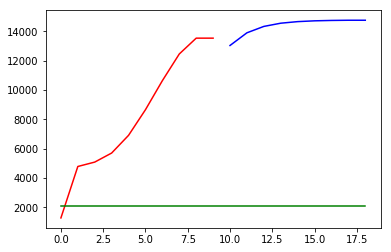

In [141]:
# plot the data
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
#, np.array(x)[:(nb_it_backward-1)], y_back, "b"
#ax.plot(np.array(x)[(nb_it_forward-1):], y_for, 'r', x, y_ref, "g")
ax.plot(np.array(x)[:nb_it_forward], y_for, 'r', np.array(x)[(nb_it_backward+1):], y_back, "b", x, y_ref, "g")

In [184]:
len(y_for)

10

In [185]:
len(np.array(x)[:(nb_it_forward)])

10

In [186]:
len(y_back)

10

In [187]:
len(np.array(x)[(nb_it_forward-1):])

10

In [156]:
y_back.insert(0, y_for[len(y_for)-1])

In [153]:
y_for[len(y_for)-1]

13537.309083696622

In [157]:
y_back

[13537.309083696622,
 13036.875268109232,
 13902.537946844692,
 14338.005300137973,
 14557.638880585797,
 14665.452059683395,
 14719.480601212214,
 14746.095138675319,
 14759.465373190505,
 14759.465373190505]

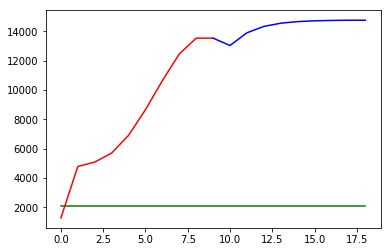

In [183]:
x = [i for i in range(nb_it_forward + nb_it_backward)]


# plot the data
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
#, np.array(x)[:(nb_it_backward-1)], y_back, "b"
#ax.plot(np.array(x)[(nb_it_forward-1):], y_for, 'r', x, y_ref, "g")
ax.plot(np.array(x)[:nb_it_forward], y_for, 'r', np.array(x)[(nb_it_forward-1):], y_back, "b", x, y_ref, "g")